In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import math
import tensorflow_addons as tfa
import time
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input ,Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, LeakyReLU, Dense

c:\Users\sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

Loading the dataset for Autoencoder

In [2]:
img_size = 128
img_channels = 3


In [ ]:
path = 'C:\\Users\\sayan\\Desktop\\anime_pics\\128x128_'
train_paths = [os.path.join(path, img) for img in os.listdir(path)]

In [4]:
train_image = list(train_paths)
train_dataset = tf.data.Dataset.from_tensor_slices(train_image)

In [5]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [img_size, img_size])
    img = (img / 127.5) - 1

    return img

train_dataset = train_dataset.map(lambda x: load_images(x))
train_dataset = train_dataset.shuffle(buffer_size=len(train_image)).batch(10).prefetch(tf.data.AUTOTUNE)

Sample image

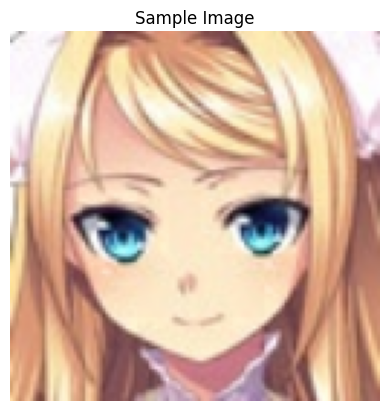

In [6]:
for _, (img) in train_dataset.take(1).enumerate():
    plt.imshow((img[0]+1)/2)
    plt.title('Sample Image')
    plt.axis('off')
    plt.show()
    break

LPIPS

In [7]:
from lpips_tensorflow import learned_perceptual_metric_model

In [8]:
model_dir = 'C:\\Users\\sayan\\Desktop\\diffusion\\lpips-tf2.x-master\\models'

vgg_ckpt_fn = os.path.join(model_dir, 'vgg', 'exported')
lin_ckpt_fn = os.path.join(model_dir, 'lin', 'exported')

lpips = learned_perceptual_metric_model(img_size, vgg_ckpt_fn, lin_ckpt_fn)

Autoencoder - U Net without the skip connections

In [9]:
depth = 3

channel_multiplier = [i for i in range(depth)]
filters = [64 * 2**mult for mult in channel_multiplier]
filters

[64, 128, 256]

In [10]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=32)

In [11]:
class AttentionBlock(layers.Layer):
    def __init__(self, units, groups=16, **kwargs):
        super(AttentionBlock,self).__init__()

        self.units = units
        self.groups = groups
        self.norm = tfa.layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init)
        self.key = layers.Dense(units, kernel_initializer=kernel_init)
        self.value = layers.Dense(units, kernel_initializer=kernel_init)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * tf.cast(self.units, tf.float32) ** (-0.5)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])
        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        out = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        return inputs + out
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'units': self.units,
            'groups': self.groups,
            'norm': self.norm,
            'query': self.query,
            'key': self.key,
            'value': self.value,
        })

swish(x) = x * sigmoid(x) where sigmoid (x) = 1 / ( 1+e^(-x) )

In [12]:
def ResidualBlock(filters, groups=16):
    def apply(inputs):
        x = inputs
        input_width = x.shape[3]

        if input_width == filters:
            residual = x
        else:
            residual = layers.Conv2D(filters, kernel_size=1, kernel_initializer=kernel_init)(x)

        x = tfa.layers.GroupNormalization(groups=groups)(x)
        x = keras.activations.swish(x)                                                    
        x = layers.Conv2D( filters, kernel_size=3, padding="same", kernel_initializer=kernel_init)(x)

        x = tfa.layers.GroupNormalization(groups=groups)(x)
        x = keras.activations.swish(x)
        x = layers.Conv2D(filters, kernel_size=3, padding="same", kernel_initializer=kernel_init)(x)
        
        x = layers.Add()([x, residual])
        return x

    return apply

In [13]:
def build_model(img_size, img_channels, filters, norm_groups=16):
  
  def encoder():  
    image_input = layers.Input(shape=(img_size, img_size, img_channels), name="image_input")

    x = layers.Conv2D(filters[0], kernel_size=(3, 3), padding="same", kernel_initializer=kernel_init)(image_input)

    #DownBlock
    for i in range(len(filters)):

        x = ResidualBlock(filters[i], groups=norm_groups)(x)

        if i != len(filters) - 1:
             x = layers.Conv2D(filters[i], 3, strides=2, padding="same", kernel_initializer=kernel_init)(x) 

    # MiddleBlock
    x = ResidualBlock(filters[-1], groups=norm_groups)(x)
    x = AttentionBlock(filters[-1], groups=norm_groups)(x)
    x = ResidualBlock(filters[-1], groups=norm_groups)(x)

    x = tfa.layers.GroupNormalization(groups=norm_groups)(x)
    x = keras.activations.swish(x)
    out = layers.Conv2D(img_channels*2, kernel_size=3, padding="same", kernel_initializer=kernel_init)(x) 
    
    return Model(inputs = image_input, outputs = out, name="encoder")

  def decoder():

    # UpBlock
    image_input = layers.Input(shape=(img_size//2**(len(filters)-1), img_size//2**(len(filters)-1), img_channels), name="image_input")

    x = layers.Conv2D(filters[-1], kernel_size=(3, 3), padding="same", kernel_initializer=kernel_init)(image_input)

    for i in reversed(range(len(filters))):

        x = ResidualBlock(filters[i], groups=norm_groups)(x)
   
        if i != 0:
            x = layers.Conv2DTranspose(filters[i], 3, strides=2, padding='same', kernel_initializer=kernel_init)(x)

    x = tfa.layers.GroupNormalization(groups=norm_groups)(x)
    x = keras.activations.swish(x)
    x = layers.Conv2D(img_channels, (3, 3), padding="same", kernel_initializer=kernel_init, activation = tf.keras.activations.tanh)(x)
    return Model(image_input, x, name="decoder")
  
  return encoder(), decoder()

In [14]:
enc, dec = build_model(img_size, img_channels, filters)

In [15]:
def meanvar(x, encoder, training=True):
    mean, logvar = tf.split(encoder(x, training=True), num_or_size_splits=2, axis=-1)
    return mean, logvar
def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
def decode(z, decoder):
    logits = decoder(z)
    return logits

Patch Discriminator

In [16]:
def make_discriminator(filters=filters, img_size=img_size, img_channels=img_channels, norm_groups=16):

    input=Input(shape=[img_size,img_size,img_channels], name='input')
    target=Input(shape=[img_size,img_size,img_channels], name='target')

    x=Concatenate()([input,target])

    x = layers.Conv2D(filters[0], kernel_size=(3, 3), padding="same", kernel_initializer=kernel_init)(x)
    
    for i in range(len(filters)-1):
            x = ResidualBlock(filters[i], groups=norm_groups)(x)
            x = layers.Conv2D(filters[i], 3, strides=2, padding="same", kernel_initializer=kernel_init)(x)
    

    zero_pad=tf.keras.layers.ZeroPadding2D()(x)
    conv=Conv2D(512, 4, strides=1, kernel_initializer=kernel_init, use_bias=False)(zero_pad)
    batchnorm=BatchNormalization()(conv)
    leakyrelu=LeakyReLU(alpha=0.2)(batchnorm)
    zero_pad=tf.keras.layers.ZeroPadding2D()(leakyrelu)

    out=Conv2D(1, 4, strides=1, kernel_initializer=kernel_init)(zero_pad)

    return Model(inputs=[input,target], outputs=out)

In [17]:
discriminator = make_discriminator()

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss +  100*l1_loss

  return total_gen_loss, gan_loss, l1_loss

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_object(tf.ones_like(real), real)

  generated_loss = loss_object(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Autoencoder loss = Reconstruction loss (MSE) + KL Divergence (wrt. Normal distribution N(0,I)) + Generator loss (L1 loss + Discriminator BCE) + Perceptual loss (using VGG16)

In [21]:
@tf.function
def train_auto(image):
    with tf.GradientTape() as enctape, tf.GradientTape() as dectape, tf.GradientTape() as dtape:

        
        mean, logvar = meanvar(image, enc)
        z = reparameterize(mean, logvar)
        generated_image=dec(z, training=True)

        real=discriminator([image,image], training=True)
        fake=discriminator([image,generated_image], training=True)

        gen_loss,_,_=generator_loss(fake, generated_image, image)
        disc_loss = discriminator_loss(real, fake)

        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(image, generated_image))
        reconstruction_loss *= img_size * img_size * img_channels
        kl_loss = tf.square(mean) + tf.exp(logvar) - 1 - logvar
        kl_loss =  0.5 * tf.reduce_mean(kl_loss)

        gen_loss+= reconstruction_loss +  kl_loss + tf.reduce_mean(lpips([generated_image, image]))

        

    gradients_of_encoder = enctape.gradient(gen_loss, enc.trainable_variables)
    gradients_of_decoder = dectape.gradient(gen_loss, dec.trainable_variables)
    gradients_of_discriminator = dtape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_decoder, dec.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def generate(model1,model2, input):

    mean, logvar = meanvar(input, model1, training=True)
    z = reparameterize(mean, logvar)
    prediction=model2(z, training= True)
    plt.figure(figsize=(16,16))

    display=[input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
     plt.subplot(1, 2, i+1)
     plt.title(title[i])
     plt.imshow(display[i] * 0.5 + 0.5)
     plt.axis('off')
    plt.show()

In [23]:
def fit(train_ds,  epochs):

  for epoch, (input_image) in train_ds.repeat().take(epochs).enumerate():
    if epoch % 1000 == 0:

      if epoch != 0:
        print(f'Time taken for 1000 epochs: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate(enc,dec, input_image)
      print(f"Epoch: {epoch//1000}k")

    train_auto(input_image)

    # Training step
    if (epoch+1) % 10 == 0:
      print('.', end='', flush=True)


In [24]:
enc.load_weights('LDM_encoder.h5')
dec.load_weights('LDM_decoder.h5')
discriminator.load_weights('LDM_discriminator.h5')

In [ ]:
fit(train_dataset,  epochs=75000)

In [26]:
encoder = enc
decoder = dec

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


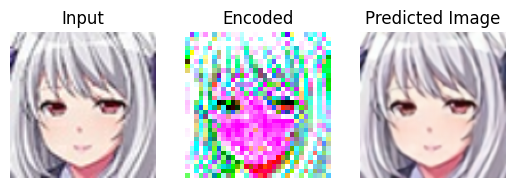

In [27]:
for _,(j) in train_dataset.enumerate().take(1):

 a,b = meanvar(j, enc, False)
 b = reparameterize(a,b)
 d = decoder(b, training=False)
 
 display=[j[0], b[0],  d[0]]
 title = ['Input','Encoded',  'Predicted Image']

 for i in range(3):
     plt.subplot(1, 3, i+1)
     plt.title(title[i])
     plt.imshow(display[i] * 0.5 + 0.5)
     plt.axis('off')
 plt.show()
 

In [30]:
#enc.save_weights('LDM_encoder.h5')
#dec.save_weights('LDM_decoder.h5')
#discriminator.save_weights('LDM_discriminator.h5')'''

Preparing for Diffusion Model

In [31]:
train_image = list(train_paths)
train_dataset = tf.data.Dataset.from_tensor_slices(train_image)

In [32]:
train_dataset = train_dataset.map(lambda x: load_images(x))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(16).prefetch(tf.data.AUTOTUNE)

Diffusion Model

In [33]:
new_img_size = img_size // 2**(len(filters)-1)
new_filters = [64 * 2**i for i in range( len(filters) + 1)]
new_filters

[64, 128, 256, 512]

In [34]:
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = tf.linspace(beta_start, beta_end, timesteps)                   #beta schedule

alphas = 1 - betas
alphas_cumprod = tf.math.cumprod(alphas)                               # cumulative product of alpha
alphas_cumprod_prev = tf.concat([[1.0], alphas_cumprod[:-1]], axis=0)  # previous cumulative product

sqrt_alphas_cumprod = tf.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.sqrt(1.0 - alphas_cumprod)
sqrt_reciprocal_alphas_cumprod = tf.sqrt(1.0 / alphas_cumprod)

In [35]:
def forward_diffusion(x0, t, func_sqrt_alphas_cumprod = sqrt_alphas_cumprod,func_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod):
        ''' given x0 and t, returns xt and noise '''
        
        noise = tf.random.normal(tf.shape(x0))
        
        sqrt_alphas_cumprod_t = tf.gather(func_sqrt_alphas_cumprod, t)
        sqrt_one_minus_alphas_cumprod_t = tf.gather(func_sqrt_one_minus_alphas_cumprod, t)
        
        # reshape for broadcasting
        sqrt_alphas_cumprod_t = tf.reshape(sqrt_alphas_cumprod_t, [-1, 1, 1, 1])
        sqrt_one_minus_alphas_cumprod_t = tf.reshape(sqrt_one_minus_alphas_cumprod_t, [-1, 1, 1, 1])
   
        xt = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise #forward process    
        
        return xt, noise

In [36]:
def reverse_diffusion( xt, t, predicted_noise, func_alphas = alphas, func_alphas_cumprod = alphas_cumprod, func_alphas_cumprod_prev = alphas_cumprod_prev, func_betas = betas):
        ''' given xt, t, and original noise added/ predicted noise, returns x_prev ''' 

        alpha_t = tf.gather(func_alphas, t)
        alpha_cumprod_t = tf.gather(func_alphas_cumprod, t)
        alpha_cumprod_prev_t = tf.gather(func_alphas_cumprod_prev, t)
        beta_t = tf.gather(func_betas, t)
        
        # Reshape for broadcasting
        alpha_t = tf.reshape(alpha_t, [-1, 1, 1, 1])
        alpha_cumprod_t = tf.reshape(alpha_cumprod_t, [-1, 1, 1, 1])
        alpha_cumprod_prev_t = tf.reshape(alpha_cumprod_prev_t, [-1, 1, 1, 1])
        beta_t = tf.reshape(beta_t, [-1, 1, 1, 1])
        
        mean = (1.0 / tf.sqrt(alpha_t)) * (xt - (beta_t / tf.sqrt(1.0 - alpha_cumprod_t)) * predicted_noise)
        var = beta_t * (1.0 - alpha_cumprod_prev_t) / (1.0 - alpha_cumprod_t)
       
        noise = tf.random.normal(tf.shape(xt))

        nonzero_mask = tf.reshape(tf.cast(t != 0, tf.float32), [-1, 1, 1, 1]) #if first step, no noise is added
        
        x_prev = mean + nonzero_mask * tf.sqrt(var) * noise
        return x_prev

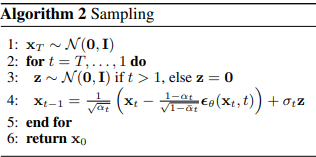

In [37]:
def sample(func_model, num_steps=None, batch_size=1):
        if num_steps is None:
            num_steps = 1000

        xt = tf.random.normal((batch_size, new_img_size, new_img_size, img_channels)) #last step of reverse diffusion starts with random noise
        
        # Reverse diffusion
        for i in reversed(range(num_steps)):
            t = tf.fill([batch_size], i)

            '''for each step, we predict the original noise added to x0 to give xt, and use it to get x_prev
            jumping directly from xt to x0 given predicted noise will make it not a meaningful image, we need to go step by step'''
            predicted_noise = func_model([xt, t], training=False) 
            xt = reverse_diffusion(xt, t, predicted_noise)
            
        return xt

In [38]:
def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        time_emb = layers.Dense(units, activation=activation_fn, kernel_initializer=kernel_init)(inputs)
        time_emb = layers.Dense(units, kernel_initializer=kernel_init)(time_emb)
        return time_emb
    return apply

def time_embedding(timesteps, dim):
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)                    # a = 2 * ln(10000)/ d
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb) # e^(-a * i) where i runs from 0 to half_dim-1
        time = tf.cast(timesteps, dtype=tf.float32)               # pos
        emb = time[:, None] * emb[None, :]                        # pos * e^(-a * i)
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)      # [sin(pos * e^(-2 i ln(10000)/ d)) , cos(pos * e^(-2 i ln(10000)/ d)] where i runs from 0 to half_dim-1
        return TimeMLP(dim)(emb)

In [39]:
def ResidualBlock_time( filters,groups=16):
  def apply(inputs):
    x,t = inputs

    in_channels = x.shape[-1]
    if in_channels != filters :
        residual = layers.Conv2D(filters, kernel_size=1, padding='same',kernel_initializer=kernel_init)(x)
    else:
        residual = x

    temb = keras.activations.swish(t)
    temb = layers.Dense(filters, kernel_initializer=kernel_init)(temb)[:, None, None, :] #Reshape to match spatial dimensions
    
    x = tfa.layers.GroupNormalization(groups=groups)(x)
    x = keras.activations.swish(x)
    x = layers.Conv2D(filters, kernel_size=3,  padding='same',kernel_initializer=kernel_init)(x)
    
    x = layers.Add()([x, temb])

    x = tfa.layers.GroupNormalization(groups=groups)(x)
    x = keras.activations.swish(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same',kernel_initializer=kernel_init)(x)

    out = layers.Add()([x, residual])
    return out
  
  return apply

In [40]:
def build_model_diffusion(img_size, img_channels, filters, norm_groups=16):
 
    image_input = layers.Input(shape=(img_size, img_size, img_channels), name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(filters[0], kernel_size=(3, 3), padding="same", kernel_initializer=kernel_init)(image_input)

    temb = time_embedding(time_input, 64 * 4)

    skips = [x]
  
    #DownBlock
    for i in range(len(filters)):

        x = ResidualBlock_time(filters[i], groups=norm_groups)([x, temb])
        x = AttentionBlock(filters[i], groups=norm_groups)(x)
        skips.append(x)

        if i != len(filters) - 1:
             x = layers.Conv2D(filters[i], 3, strides=2, padding="same", kernel_initializer=kernel_init)(x) 

    # MiddleBlock
    x = ResidualBlock_time(filters[-1], groups=norm_groups)([x, temb])
    x = AttentionBlock(filters[-1], groups=norm_groups)(x)
    x = ResidualBlock_time(filters[-1], groups=norm_groups)([x, temb])

    # UpBlock
    for i in reversed(range(len(filters))):
        x = layers.Concatenate(axis=-1)([x, skips.pop()])
        x = ResidualBlock_time(filters[i], groups=norm_groups)([x, temb])
        x = AttentionBlock(filters[i], groups=norm_groups)(x)
        if i != 0:
            x = layers.Conv2DTranspose(filters[i], 3, strides=2, padding='same', kernel_initializer=kernel_init)(x)

    x = tfa.layers.GroupNormalization(groups=norm_groups)(x)
    x = keras.activations.swish(x)
    x = layers.Conv2D(img_channels, (3, 3), padding="same", kernel_initializer=kernel_init)(x)
    return keras.Model([image_input, time_input], x, name="unet_")


In [41]:
diffusion_model = build_model_diffusion(new_img_size, img_channels, new_filters)

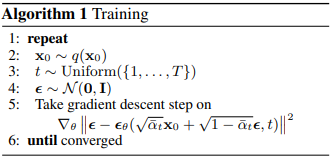

In [42]:
def train_step_(x_batch):
        batch_size = tf.shape(x_batch)[0]
        t = tf.random.uniform([batch_size], 0, timesteps, dtype=tf.int32) # sample random timesteps
        with tf.GradientTape() as tape:
            
            xt, noise = forward_diffusion(x_batch, t)# forward diffusion
            predicted_noise = diffusion_model([xt, t], training=True)# Predict noise
            loss = tf.reduce_mean(tf.square(noise - predicted_noise))# compute loss (MSE between actual and predicted noise)
        
        gradients = tape.gradient(loss, diffusion_model.trainable_variables)
        return loss, gradients #gradients and loss

def train_diffusion_model(diffusion_model, dataset, epochs=100, learning_rate=1e-4):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    diffusion_model.compile(optimizer=optimizer)
    
    @tf.function
    def train_step(x_batch):
        loss, gradients = train_step_(x_batch)
        optimizer.apply_gradients(zip(gradients, diffusion_model.trainable_variables))
        return loss
    
    #training loop
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for batch in dataset:
            mean, var = meanvar(batch, enc, training=False)
            batch_ = reparameterize(mean, var)
            loss = train_step(batch_)
            epoch_loss += loss
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        
        # Generate samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            samples = sample(diffusion_model,batch_size=4)
            decoded_samples = decoder(samples, training=False)
            
            
            # Plot samples
            fig, axes = plt.subplots(1, 4, figsize=(12, 3))
            for i in range(4):
                axes[i].imshow(decoded_samples[i])
                axes[i].axis('off')

            plt.title(f"Generated samples at epoch {epoch + 1}")
            plt.show()

In [43]:
diffusion_model.load_weights('diffusion_model_LDM.h5')

In [ ]:
train_diffusion_model(diffusion_model, train_dataset, epochs=400)

In [47]:
#diffusion_model.save_weights('diffusion_model_LDM.h5')

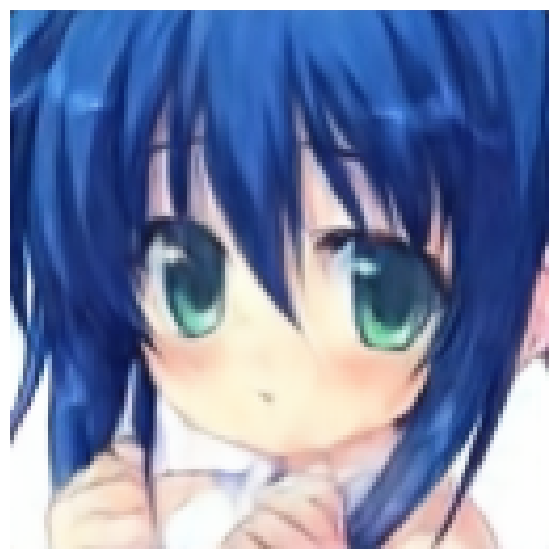

In [63]:
plot = sample(diffusion_model, num_steps=timesteps, batch_size=1)
decoded_plot = dec(plot, training=False)
plt.figure(figsize=(7,7))
plt.imshow((decoded_plot[0]+1)/2)
plt.axis('off')
plt.show()